In [131]:
# Set to false if working on local env
onColab = True

model_path = './baseline_3'

# Decide batch size and validation split
batch_size = 128
validation_split = 0.2
test_split = 0.01
epochs = 200

dataset_path = './Training.csv'

window = 500
stride = 10
# 864 / 8
telescope = 108


In [132]:
def preprocess(dataset):
  return dataset
def postprocess(res):
  return res

In [133]:
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/University/ANN/CHALLENGE2
baseline    baseline_2_ckpt  baseline.ipynb  simple	  Training.csv
baseline_2  baseline_ckpt    model.png	     simple_ckpt


In [134]:
#@title Import libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [135]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [136]:
dataset  = pd.read_csv(dataset_path)
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [137]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


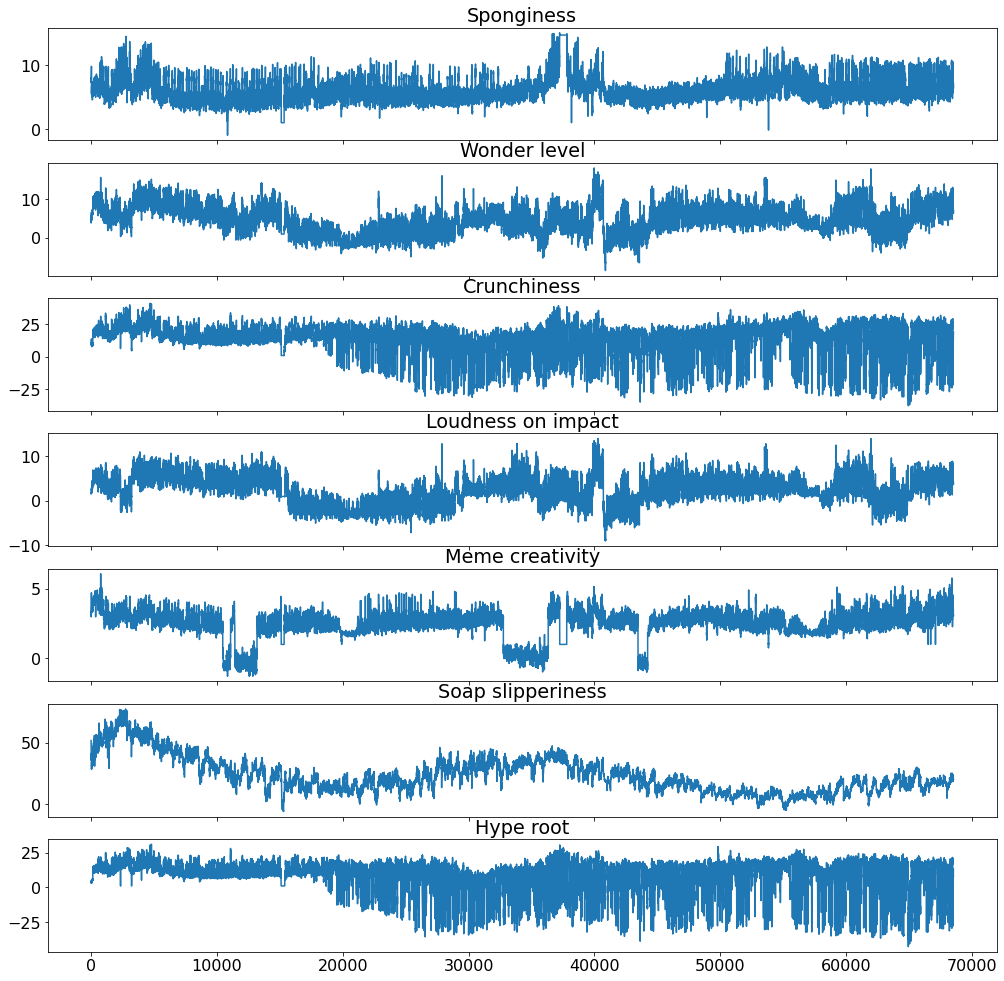

In [138]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

In [139]:
test_size = round(dataset.shape[0] * test_split)
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_noNorm = X_train_raw
X_test_noNorm = X_test_raw

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)


(67843, 7) (685, 7)


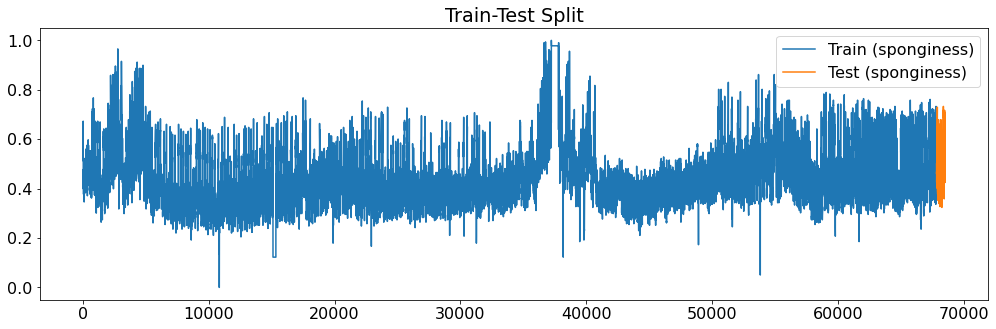

In [140]:
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [141]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 500, 7)

In [142]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [143]:
target_labels = dataset.columns

In [144]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6740, 500, 7), (6740, 108, 7), (40, 500, 7), (40, 108, 7))

In [145]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [146]:
X_train.shape

(6740, 500, 7)

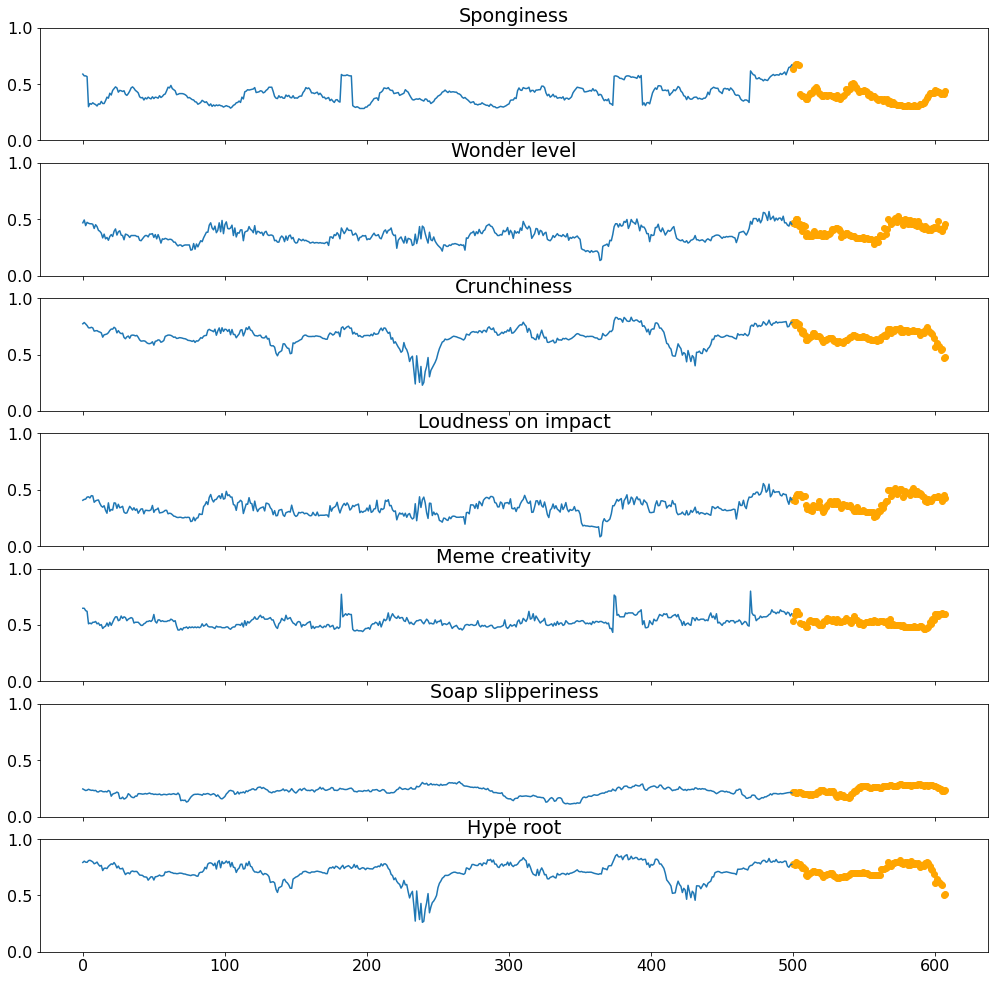

In [147]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [148]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
input_shape, output_shape

((500, 7), (108, 7))

In [149]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 500, 7)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 128)         36864     
 nal)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 500, 128)          49280     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 250, 128)         0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 250, 256)         263168    
 nal)                                                            
                                                             

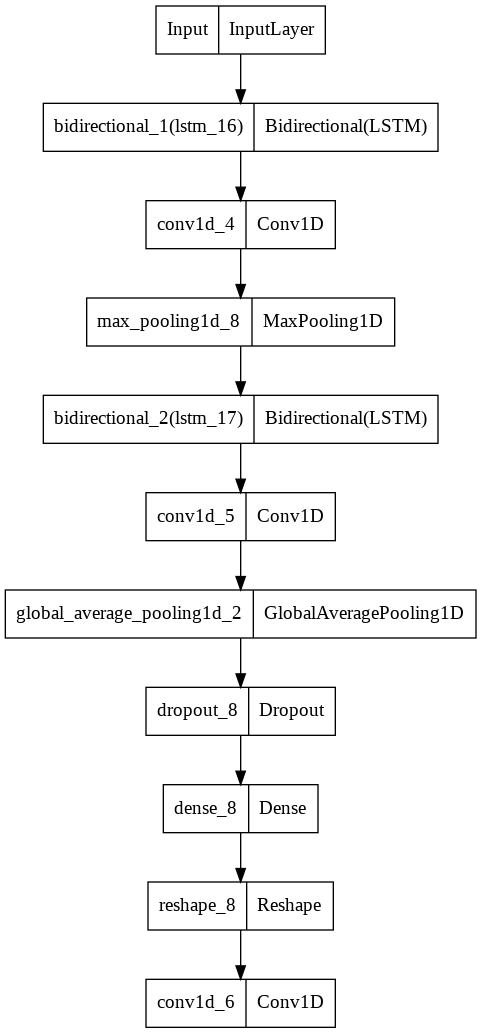

In [150]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [151]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
        tfk.callbacks.ModelCheckpoint(model_path + '_ckpt', save_best_only=True)
    ]
).history

Epoch 1/200
43/43 [==============================] - ETA: 0s - loss: 0.0888 - mae: 0.2375

43/43 [==============================] - 59s 1s/step - loss: 0.0888 - mae: 0.2375 - val_loss: 0.0483 - val_mae: 0.1878 - lr: 0.0010
Epoch 2/200
43/43 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.1375

43/43 [==============================] - 48s 1s/step - loss: 0.0301 - mae: 0.1375 - val_loss: 0.0310 - val_mae: 0.1460 - lr: 0.0010
Epoch 3/200
43/43 [==============================] - ETA: 0s - loss: 0.0216 - mae: 0.1138

43/43 [==============================] - 48s 1s/step - loss: 0.0216 - mae: 0.1138 - val_loss: 0.0232 - val_mae: 0.1162 - lr: 0.0010
Epoch 4/200
43/43 [==============================] - ETA: 0s - loss: 0.0187 - mae: 0.1054

43/43 [==============================] - 48s 1s/step - loss: 0.0187 - mae: 0.1054 - val_loss: 0.0206 - val_mae: 0.1090 - lr: 0.0010
Epoch 5/200
43/43 [==============================] - ETA: 0s - loss: 0.0179 - mae: 0.1032

43/43 [==============================] - 48s 1s/step - loss: 0.0179 - mae: 0.1032 - val_loss: 0.0202 - val_mae: 0.1101 - lr: 0.0010
Epoch 6/200
43/43 [==============================] - ETA: 0s - loss: 0.0172 - mae: 0.1010

43/43 [==============================] - 48s 1s/step - loss: 0.0172 - mae: 0.1010 - val_loss: 0.0194 - val_mae: 0.1042 - lr: 0.0010
Epoch 7/200
43/43 [==============================] - ETA: 0s - loss: 0.0166 - mae: 0.0991

43/43 [==============================] - 48s 1s/step - loss: 0.0166 - mae: 0.0991 - val_loss: 0.0194 - val_mae: 0.1053 - lr: 0.0010
Epoch 8/200
43/43 [==============================] - ETA: 0s - loss: 0.0163 - mae: 0.0982

43/43 [==============================] - 48s 1s/step - loss: 0.0163 - mae: 0.0982 - val_loss: 0.0193 - val_mae: 0.1055 - lr: 0.0010
Epoch 9/200
43/43 [==============================] - ETA: 0s - loss: 0.0160 - mae: 0.0971

43/43 [==============================] - 47s 1s/step - loss: 0.0160 - mae: 0.0971 - val_loss: 0.0193 - val_mae: 0.1041 - lr: 0.0010
Epoch 10/200
43/43 [==============================] - ETA: 0s - loss: 0.0157 - mae: 0.0961

43/43 [==============================] - 47s 1s/step - loss: 0.0157 - mae: 0.0961 - val_loss: 0.0192 - val_mae: 0.1024 - lr: 0.0010
Epoch 11/200
43/43 [==============================] - ETA: 0s - loss: 0.0154 - mae: 0.0948

43/43 [==============================] - 48s 1s/step - loss: 0.0154 - mae: 0.0948 - val_loss: 0.0189 - val_mae: 0.1013 - lr: 0.0010
Epoch 12/200
43/43 [==============================] - ETA: 0s - loss: 0.0152 - mae: 0.0940

43/43 [==============================] - 48s 1s/step - loss: 0.0152 - mae: 0.0940 - val_loss: 0.0189 - val_mae: 0.1007 - lr: 0.0010
Epoch 13/200
43/43 [==============================] - ETA: 0s - loss: 0.0150 - mae: 0.0932

43/43 [==============================] - 48s 1s/step - loss: 0.0150 - mae: 0.0932 - val_loss: 0.0185 - val_mae: 0.1016 - lr: 0.0010
Epoch 14/200
43/43 [==============================] - ETA: 0s - loss: 0.0147 - mae: 0.0922

43/43 [==============================] - 48s 1s/step - loss: 0.0147 - mae: 0.0922 - val_loss: 0.0183 - val_mae: 0.0980 - lr: 0.0010
Epoch 15/200
43/43 [==============================] - ETA: 0s - loss: 0.0146 - mae: 0.0920

43/43 [==============================] - 47s 1s/step - loss: 0.0146 - mae: 0.0920 - val_loss: 0.0180 - val_mae: 0.0981 - lr: 0.0010
Epoch 16/200
43/43 [==============================] - ETA: 0s - loss: 0.0142 - mae: 0.0903

43/43 [==============================] - 47s 1s/step - loss: 0.0142 - mae: 0.0903 - val_loss: 0.0177 - val_mae: 0.0980 - lr: 0.0010
Epoch 17/200
43/43 [==============================] - 16s 361ms/step - loss: 0.0139 - mae: 0.0892 - val_loss: 0.0178 - val_mae: 0.0981 - lr: 0.0010
Epoch 18/200
43/43 [==============================] - ETA: 0s - loss: 0.0138 - mae: 0.0887

43/43 [==============================] - 47s 1s/step - loss: 0.0138 - mae: 0.0887 - val_loss: 0.0175 - val_mae: 0.0957 - lr: 0.0010
Epoch 19/200
43/43 [==============================] - 15s 358ms/step - loss: 0.0136 - mae: 0.0879 - val_loss: 0.0178 - val_mae: 0.0987 - lr: 0.0010
Epoch 20/200
43/43 [==============================] - ETA: 0s - loss: 0.0134 - mae: 0.0870

43/43 [==============================] - 47s 1s/step - loss: 0.0134 - mae: 0.0870 - val_loss: 0.0174 - val_mae: 0.0963 - lr: 0.0010
Epoch 21/200
43/43 [==============================] - ETA: 0s - loss: 0.0132 - mae: 0.0864

43/43 [==============================] - 48s 1s/step - loss: 0.0132 - mae: 0.0864 - val_loss: 0.0172 - val_mae: 0.0951 - lr: 0.0010
Epoch 22/200
43/43 [==============================] - 16s 361ms/step - loss: 0.0131 - mae: 0.0858 - val_loss: 0.0173 - val_mae: 0.0970 - lr: 0.0010
Epoch 23/200
43/43 [==============================] - 15s 359ms/step - loss: 0.0128 - mae: 0.0849 - val_loss: 0.0172 - val_mae: 0.0946 - lr: 0.0010
Epoch 24/200
43/43 [==============================] - ETA: 0s - loss: 0.0128 - mae: 0.0848

43/43 [==============================] - 48s 1s/step - loss: 0.0128 - mae: 0.0848 - val_loss: 0.0172 - val_mae: 0.0953 - lr: 0.0010
Epoch 25/200
43/43 [==============================] - ETA: 0s - loss: 0.0126 - mae: 0.0839

43/43 [==============================] - 48s 1s/step - loss: 0.0126 - mae: 0.0839 - val_loss: 0.0169 - val_mae: 0.0942 - lr: 0.0010
Epoch 26/200
43/43 [==============================] - ETA: 0s - loss: 0.0125 - mae: 0.0836

43/43 [==============================] - 47s 1s/step - loss: 0.0125 - mae: 0.0836 - val_loss: 0.0168 - val_mae: 0.0931 - lr: 0.0010
Epoch 27/200
43/43 [==============================] - 15s 358ms/step - loss: 0.0123 - mae: 0.0828 - val_loss: 0.0172 - val_mae: 0.0964 - lr: 0.0010
Epoch 28/200
43/43 [==============================] - ETA: 0s - loss: 0.0123 - mae: 0.0827

43/43 [==============================] - 47s 1s/step - loss: 0.0123 - mae: 0.0827 - val_loss: 0.0164 - val_mae: 0.0929 - lr: 0.0010
Epoch 29/200
43/43 [==============================] - 15s 358ms/step - loss: 0.0121 - mae: 0.0817 - val_loss: 0.0167 - val_mae: 0.0944 - lr: 0.0010
Epoch 30/200
43/43 [==============================] - 15s 358ms/step - loss: 0.0120 - mae: 0.0815 - val_loss: 0.0167 - val_mae: 0.0935 - lr: 0.0010
Epoch 31/200
43/43 [==============================] - ETA: 0s - loss: 0.0118 - mae: 0.0804

43/43 [==============================] - 47s 1s/step - loss: 0.0118 - mae: 0.0804 - val_loss: 0.0164 - val_mae: 0.0929 - lr: 0.0010
Epoch 32/200
43/43 [==============================] - ETA: 0s - loss: 0.0116 - mae: 0.0798

43/43 [==============================] - 47s 1s/step - loss: 0.0116 - mae: 0.0798 - val_loss: 0.0163 - val_mae: 0.0920 - lr: 0.0010
Epoch 33/200
43/43 [==============================] - 15s 358ms/step - loss: 0.0115 - mae: 0.0793 - val_loss: 0.0163 - val_mae: 0.0921 - lr: 0.0010
Epoch 34/200
43/43 [==============================] - ETA: 0s - loss: 0.0114 - mae: 0.0788

43/43 [==============================] - 48s 1s/step - loss: 0.0114 - mae: 0.0788 - val_loss: 0.0156 - val_mae: 0.0890 - lr: 0.0010
Epoch 35/200
43/43 [==============================] - ETA: 0s - loss: 0.0109 - mae: 0.0774

43/43 [==============================] - 48s 1s/step - loss: 0.0109 - mae: 0.0774 - val_loss: 0.0149 - val_mae: 0.0882 - lr: 0.0010
Epoch 36/200
43/43 [==============================] - ETA: 0s - loss: 0.0106 - mae: 0.0764

43/43 [==============================] - 49s 1s/step - loss: 0.0106 - mae: 0.0764 - val_loss: 0.0144 - val_mae: 0.0860 - lr: 0.0010
Epoch 37/200
43/43 [==============================] - ETA: 0s - loss: 0.0103 - mae: 0.0750

43/43 [==============================] - 48s 1s/step - loss: 0.0103 - mae: 0.0750 - val_loss: 0.0144 - val_mae: 0.0863 - lr: 0.0010
Epoch 38/200
43/43 [==============================] - ETA: 0s - loss: 0.0102 - mae: 0.0748

43/43 [==============================] - 47s 1s/step - loss: 0.0102 - mae: 0.0748 - val_loss: 0.0136 - val_mae: 0.0840 - lr: 0.0010
Epoch 39/200
43/43 [==============================] - ETA: 0s - loss: 0.0098 - mae: 0.0731

43/43 [==============================] - 47s 1s/step - loss: 0.0098 - mae: 0.0731 - val_loss: 0.0128 - val_mae: 0.0826 - lr: 0.0010
Epoch 40/200
43/43 [==============================] - 16s 362ms/step - loss: 0.0093 - mae: 0.0716 - val_loss: 0.0131 - val_mae: 0.0850 - lr: 0.0010
Epoch 41/200
43/43 [==============================] - 15s 359ms/step - loss: 0.0091 - mae: 0.0709 - val_loss: 0.0130 - val_mae: 0.0846 - lr: 0.0010
Epoch 42/200
43/43 [==============================] - ETA: 0s - loss: 0.0085 - mae: 0.0685

43/43 [==============================] - 47s 1s/step - loss: 0.0085 - mae: 0.0685 - val_loss: 0.0110 - val_mae: 0.0772 - lr: 0.0010
Epoch 43/200
43/43 [==============================] - ETA: 0s - loss: 0.0082 - mae: 0.0671

43/43 [==============================] - 47s 1s/step - loss: 0.0082 - mae: 0.0671 - val_loss: 0.0109 - val_mae: 0.0769 - lr: 0.0010
Epoch 44/200
43/43 [==============================] - 16s 360ms/step - loss: 0.0079 - mae: 0.0659 - val_loss: 0.0112 - val_mae: 0.0801 - lr: 0.0010
Epoch 45/200
43/43 [==============================] - ETA: 0s - loss: 0.0079 - mae: 0.0662

43/43 [==============================] - 47s 1s/step - loss: 0.0079 - mae: 0.0662 - val_loss: 0.0103 - val_mae: 0.0741 - lr: 0.0010
Epoch 46/200
43/43 [==============================] - ETA: 0s - loss: 0.0076 - mae: 0.0645

43/43 [==============================] - 47s 1s/step - loss: 0.0076 - mae: 0.0645 - val_loss: 0.0103 - val_mae: 0.0745 - lr: 0.0010
Epoch 47/200
43/43 [==============================] - ETA: 0s - loss: 0.0073 - mae: 0.0636

43/43 [==============================] - 48s 1s/step - loss: 0.0073 - mae: 0.0636 - val_loss: 0.0102 - val_mae: 0.0744 - lr: 0.0010
Epoch 48/200
43/43 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.0637

43/43 [==============================] - 48s 1s/step - loss: 0.0074 - mae: 0.0637 - val_loss: 0.0099 - val_mae: 0.0724 - lr: 0.0010
Epoch 49/200
43/43 [==============================] - ETA: 0s - loss: 0.0071 - mae: 0.0626

43/43 [==============================] - 48s 1s/step - loss: 0.0071 - mae: 0.0626 - val_loss: 0.0096 - val_mae: 0.0715 - lr: 0.0010
Epoch 50/200
43/43 [==============================] - ETA: 0s - loss: 0.0070 - mae: 0.0620

43/43 [==============================] - 47s 1s/step - loss: 0.0070 - mae: 0.0620 - val_loss: 0.0096 - val_mae: 0.0715 - lr: 0.0010
Epoch 51/200
43/43 [==============================] - ETA: 0s - loss: 0.0070 - mae: 0.0619

43/43 [==============================] - 47s 1s/step - loss: 0.0070 - mae: 0.0619 - val_loss: 0.0092 - val_mae: 0.0712 - lr: 0.0010
Epoch 52/200
43/43 [==============================] - ETA: 0s - loss: 0.0067 - mae: 0.0604

43/43 [==============================] - 47s 1s/step - loss: 0.0067 - mae: 0.0604 - val_loss: 0.0092 - val_mae: 0.0710 - lr: 0.0010
Epoch 53/200
43/43 [==============================] - 15s 357ms/step - loss: 0.0066 - mae: 0.0599 - val_loss: 0.0094 - val_mae: 0.0710 - lr: 0.0010
Epoch 54/200
43/43 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0595

43/43 [==============================] - 47s 1s/step - loss: 0.0065 - mae: 0.0595 - val_loss: 0.0089 - val_mae: 0.0699 - lr: 0.0010
Epoch 55/200
43/43 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0592

43/43 [==============================] - 47s 1s/step - loss: 0.0064 - mae: 0.0592 - val_loss: 0.0088 - val_mae: 0.0694 - lr: 0.0010
Epoch 56/200
43/43 [==============================] - 16s 360ms/step - loss: 0.0063 - mae: 0.0585 - val_loss: 0.0092 - val_mae: 0.0697 - lr: 0.0010
Epoch 57/200
43/43 [==============================] - 15s 355ms/step - loss: 0.0062 - mae: 0.0583 - val_loss: 0.0093 - val_mae: 0.0693 - lr: 0.0010
Epoch 58/200
43/43 [==============================] - ETA: 0s - loss: 0.0062 - mae: 0.0581

43/43 [==============================] - 48s 1s/step - loss: 0.0062 - mae: 0.0581 - val_loss: 0.0088 - val_mae: 0.0681 - lr: 0.0010
Epoch 59/200
43/43 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0577

43/43 [==============================] - 48s 1s/step - loss: 0.0061 - mae: 0.0577 - val_loss: 0.0087 - val_mae: 0.0683 - lr: 0.0010
Epoch 60/200
43/43 [==============================] - ETA: 0s - loss: 0.0060 - mae: 0.0572

43/43 [==============================] - 48s 1s/step - loss: 0.0060 - mae: 0.0572 - val_loss: 0.0086 - val_mae: 0.0685 - lr: 0.0010
Epoch 61/200
43/43 [==============================] - ETA: 0s - loss: 0.0060 - mae: 0.0571

43/43 [==============================] - 48s 1s/step - loss: 0.0060 - mae: 0.0571 - val_loss: 0.0086 - val_mae: 0.0680 - lr: 0.0010
Epoch 62/200
43/43 [==============================] - 16s 361ms/step - loss: 0.0059 - mae: 0.0565 - val_loss: 0.0086 - val_mae: 0.0679 - lr: 0.0010
Epoch 63/200
43/43 [==============================] - 15s 358ms/step - loss: 0.0059 - mae: 0.0565 - val_loss: 0.0089 - val_mae: 0.0690 - lr: 0.0010
Epoch 64/200
43/43 [==============================] - 15s 357ms/step - loss: 0.0058 - mae: 0.0564 - val_loss: 0.0088 - val_mae: 0.0696 - lr: 0.0010
Epoch 65/200
43/43 [==============================] - 15s 358ms/step - loss: 0.0057 - mae: 0.0556 - val_loss: 0.0089 - val_mae: 0.0684 - lr: 5.0000e-04
Epoch 66/200
43/43 [==============================] - 15s 358ms/step - loss: 0.0056 - mae: 0.0551 - val_loss: 0.0090 - val_mae: 0.0695 - lr: 5.0000e-04
Epoch 67/200
43/43 [==============================] - ETA: 0s - loss: 0.0056 - mae: 0.0552

43/43 [==============================] - 46s 1s/step - loss: 0.0056 - mae: 0.0552 - val_loss: 0.0085 - val_mae: 0.0678 - lr: 5.0000e-04
Epoch 68/200
43/43 [==============================] - 15s 358ms/step - loss: 0.0055 - mae: 0.0547 - val_loss: 0.0088 - val_mae: 0.0687 - lr: 5.0000e-04
Epoch 69/200
43/43 [==============================] - 15s 359ms/step - loss: 0.0055 - mae: 0.0547 - val_loss: 0.0091 - val_mae: 0.0697 - lr: 5.0000e-04
Epoch 70/200
43/43 [==============================] - 15s 357ms/step - loss: 0.0055 - mae: 0.0545 - val_loss: 0.0090 - val_mae: 0.0693 - lr: 5.0000e-04
Epoch 71/200
43/43 [==============================] - 15s 359ms/step - loss: 0.0054 - mae: 0.0544 - val_loss: 0.0090 - val_mae: 0.0695 - lr: 5.0000e-04
Epoch 72/200
43/43 [==============================] - 15s 358ms/step - loss: 0.0054 - mae: 0.0542 - val_loss: 0.0099 - val_mae: 0.0717 - lr: 5.0000e-04
Epoch 73/200
43/43 [==============================] - 15s 357ms/step - loss: 0.0053 - mae: 0.0538 - val_

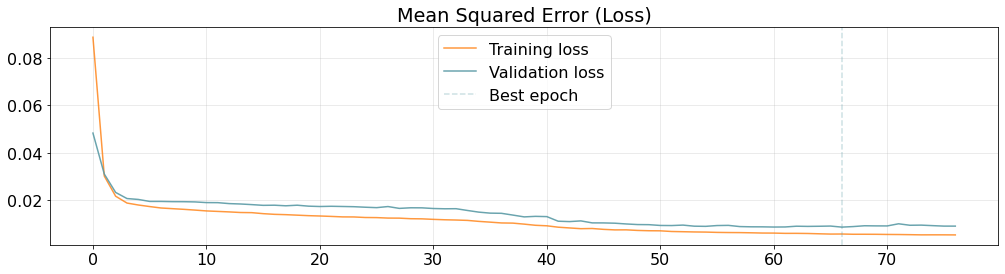

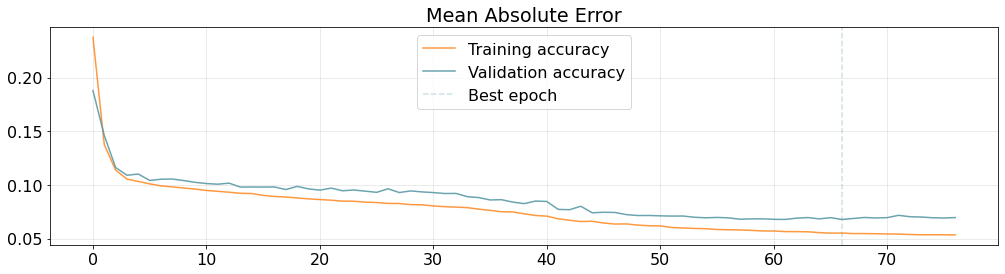

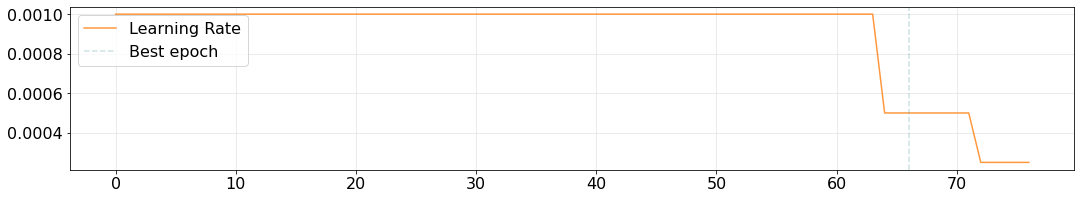

In [152]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [153]:
model.save(model_path)

In [154]:
model = tfk.models.load_model(model_path)

In [155]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(40, 108, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.008499865>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.06829978>)

In [156]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

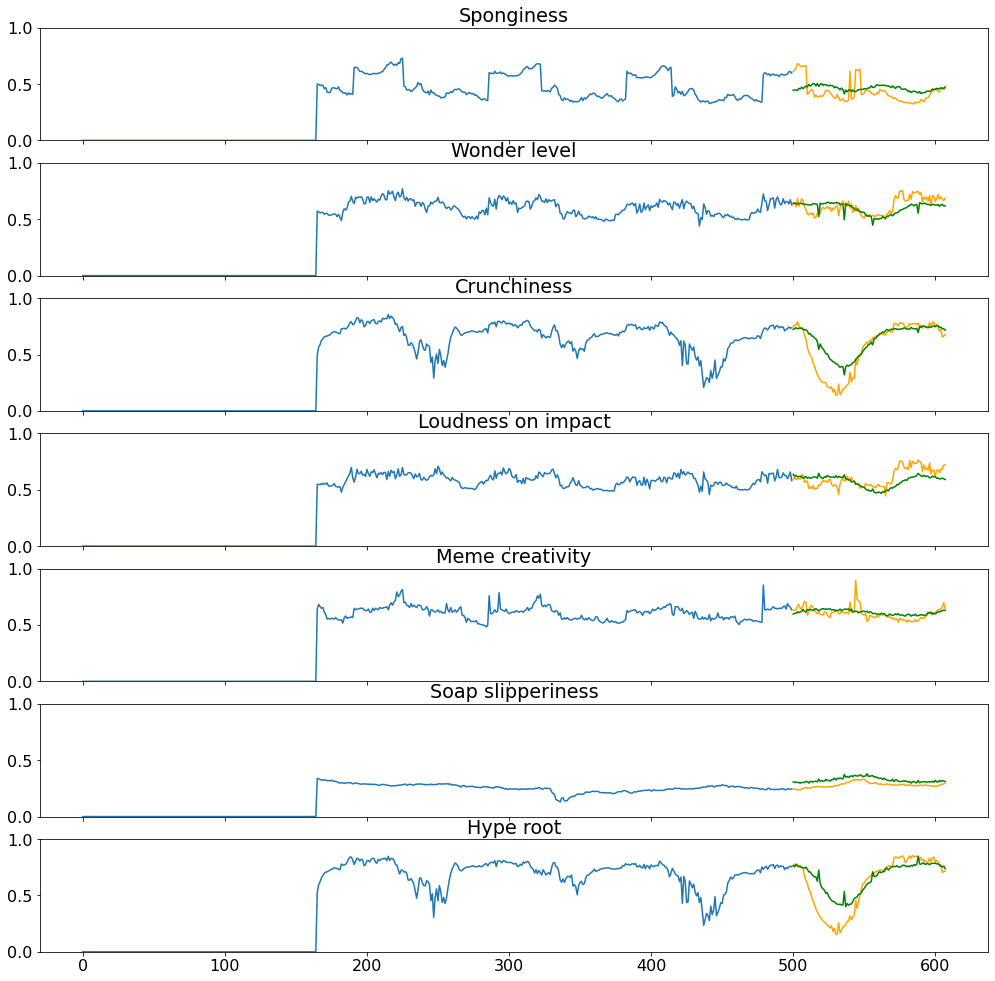

In [157]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [158]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [159]:
future_predictions = model.predict(future)

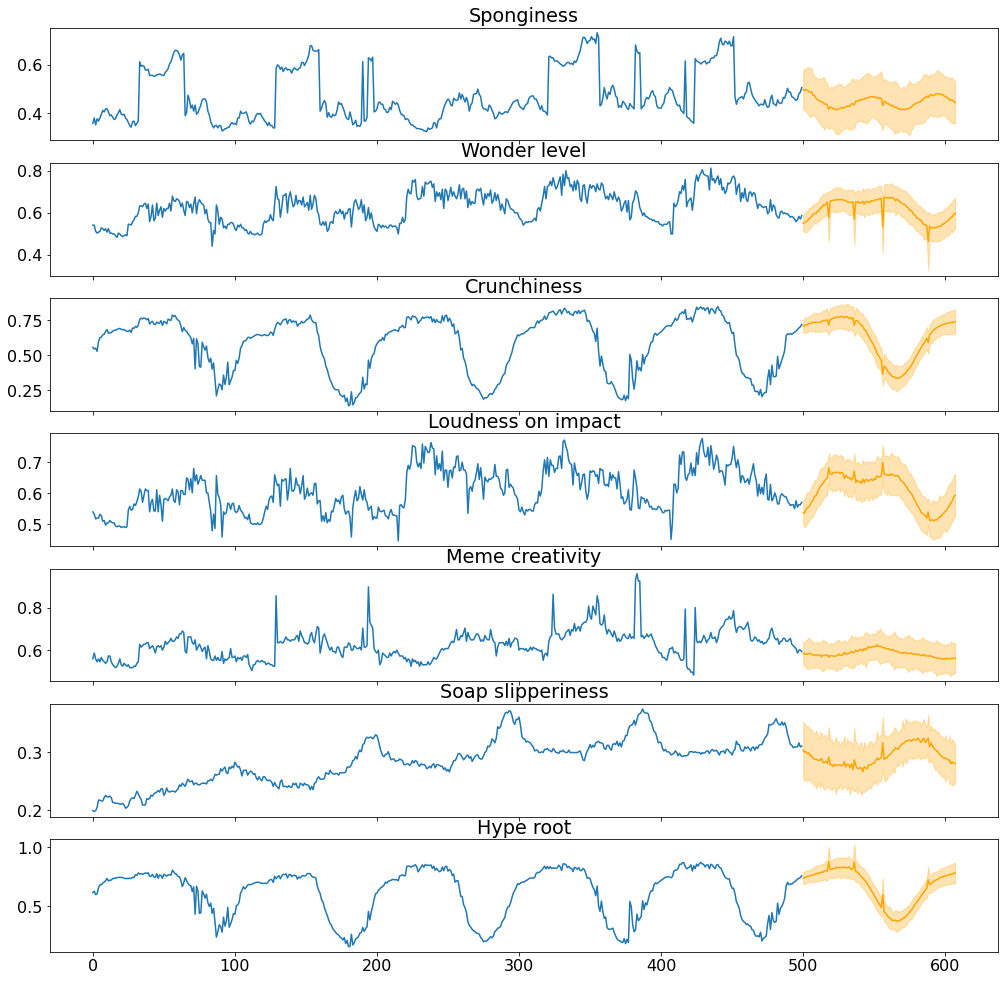

In [160]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

In [172]:
reg_telescope = 216
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((29, 500, 7), (29, 216, 7))

In [173]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [174]:
reg_predictions.shape

(29, 216, 7)

In [175]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.00964882>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07347586>)

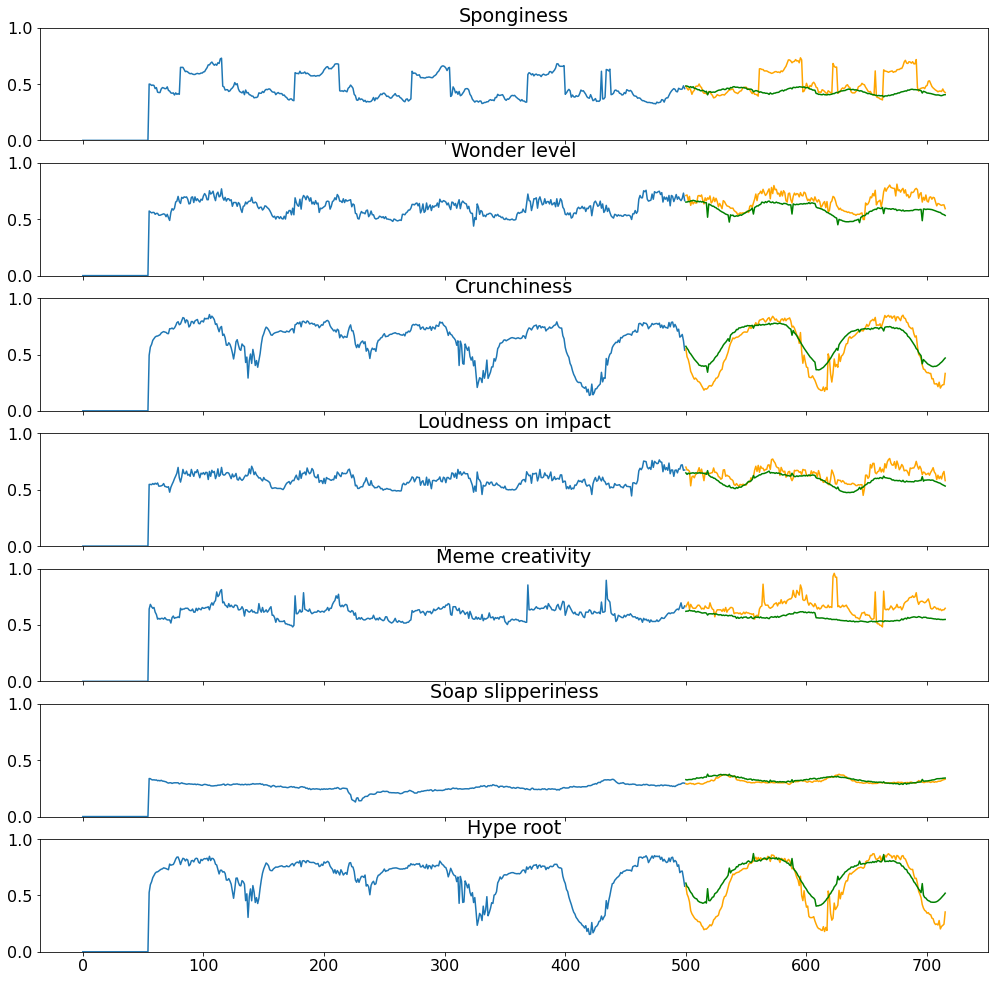

In [176]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)